In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image
import glob
import os
from sklearn.model_selection import train_test_split
from math import log, exp
from time import time
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from copy import deepcopy

In [13]:
class Booster:
    def __init__(self, n_estimators=50, learning_rate=1, random_state=None, base_learner=DecisionTreeClassifier(max_depth=2)):
        self.n_estimators_ = n_estimators
        self.learning_rate_ = learning_rate
        self.random_state_ = random_state
        self.estimators_ = []
        self.alphas_ = np.zeros(self.n_estimators_)
        self.accuracies = None
        self.base_learner_ = base_learner
    
    def plot(self):
        if not self.accuracies:
            raise ValueError("ERROR: self.accuracies not defined. Make sure self.fit() is called with visible=True")
        plt.plot([i+1 for i in range(self.n_estimators_)],self.accuracies)
        plt.xlabel("Number of estimators")
        plt.ylabel("Accuracy")
        plt.show()

    def fit(self, X, Y, verbose=False, visible=False, verbose_visibility=False):
        if visible:
            self.accuracies = []
            
        self.n_samples_ = X.shape[0]
        self.classes_ = np.array(sorted(list(set(Y))))
        self.n_classes_ = len(self.classes_)
        for i in range(self.n_estimators_):
            if i == 0:
                if verbose:
                    print(f"Iteration starting after {time()-start:.2f} seconds")
                local_alphas = np.ones(self.n_samples_) / self.n_samples_
            local_weights, estimator_alpha, estimator_error = self.boost(X, Y, local_alphas, visible)
            
            if estimator_error is None:
                break
            
            self.alphas_[i] = estimator_alpha
            
            if verbose and (i+1) % verbose == 0:
                print(f"Iteration {i+1} ended after {time()-start:.2f} seconds")
            
            if visible:
                acc_start = time()
                self.accuracies.append(self.accuracy(self.predict(X),Y))
                if verbose_visibility and (i+1) % verbose_visibility == 0:
                    print(f"Accuracy {i+1} ({self.accuracies[-1]:.2%}) took {time()-acc_start:.2f} seconds")
                
            if estimator_error <= 0:
                break
        
        if visible:
            self.plot()
        
        return self
    
    def boost(self, X, Y, weights, visible):
        estimator = deepcopy(self.base_learner_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, Y, sample_weight=weights)

        y_hat = estimator.predict(X)
        incorrect = y_hat != Y
        estimator_error = np.dot(incorrect, weights) / np.sum(weights, axis=0)

        if estimator_error >= 1 - 1 / self.n_classes_:
            return None, None, None

        estimator_weight = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(self.n_classes_ - 1)

        if estimator_weight <= 0:
            return None, None, None

        weights *= np.exp(estimator_weight * incorrect)

        w_sum = np.sum(weights, axis=0)
        if w_sum <= 0:
            return None, None, None

        weights /= w_sum

        self.estimators_.append(estimator)

        return np.array(weights), estimator_weight, estimator_error

    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = sum((estimator.predict(X) == classes).T * a for estimator, a in zip(self.estimators_, self.alphas_))
        pred /= self.alphas_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)
        
        return self.classes_.take(np.argmax(pred, axis=1), axis=0)
    
    def accuracy(self, y_hat, y_true):
        ones = np.where(y_hat == y_true, 1, 0)
        solid = np.ones((1,len(y_hat)))
        return ((ones @ ones.T) / (solid @ solid.T))[0][0]
    

In [2]:
import tensorflow as tf
import keras
from keras.datasets import mnist, fashion_mnist

In [3]:
(Xtrain,Ytrain), (Xtest,Ytest) = mnist.load_data()
Xtrain = Xtrain.astype("float32") / 255.
Xtest = Xtest.astype("float32") / 255.
Xtrain = Xtrain.reshape((len(Xtrain), np.prod(Xtrain.shape[1:])))
Xtest = Xtest.reshape((len(Xtest), np.prod(Xtest.shape[1:])))
print(Xtrain.shape)
print(Ytrain.shape)

(60000, 784)
(60000,)


Iteration starting after 0.01 seconds
Iteration 25 ended after 79.81 seconds
Accuracy 25 (70.24%) took 1.44 seconds
Iteration 50 ended after 199.25 seconds
Accuracy 50 (78.09%) took 2.75 seconds
Iteration 75 ended after 359.33 seconds
Accuracy 75 (79.96%) took 4.23 seconds
Iteration 100 ended after 545.52 seconds
Accuracy 100 (81.08%) took 6.58 seconds
Iteration 125 ended after 767.08 seconds
Accuracy 125 (83.66%) took 6.97 seconds
Iteration 150 ended after 1021.91 seconds
Accuracy 150 (83.78%) took 8.15 seconds
Iteration 175 ended after 1310.11 seconds
Accuracy 175 (84.29%) took 10.71 seconds
Iteration 200 ended after 1657.65 seconds
Accuracy 200 (85.00%) took 14.22 seconds
Iteration 225 ended after 2105.37 seconds
Accuracy 225 (84.58%) took 15.36 seconds
Iteration 250 ended after 2547.21 seconds
Accuracy 250 (85.51%) took 14.45 seconds
Iteration 275 ended after 2976.63 seconds
Accuracy 275 (85.36%) took 15.01 seconds
Iteration 300 ended after 3463.16 seconds
Accuracy 300 (85.35%) too

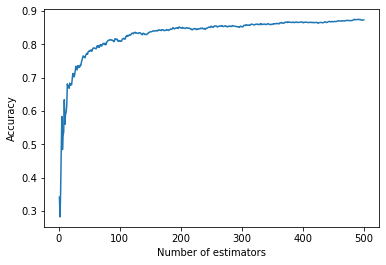

Accuracy: 87.35% over 500 trees after 8639.75 seconds


In [17]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

Iteration starting after 0.01 seconds
Iteration 25 ended after 50.87 seconds
Accuracy 25 (47.40%) took 1.38 seconds
Iteration 50 ended after 134.11 seconds
Accuracy 50 (57.53%) took 2.59 seconds
Iteration 75 ended after 249.32 seconds
Accuracy 75 (67.15%) took 3.86 seconds
Iteration 100 ended after 396.46 seconds
Accuracy 100 (70.12%) took 5.21 seconds
Iteration 125 ended after 576.07 seconds
Accuracy 125 (71.73%) took 6.40 seconds
Iteration 150 ended after 787.01 seconds
Accuracy 150 (73.47%) took 7.61 seconds
Iteration 175 ended after 1030.94 seconds
Accuracy 175 (74.01%) took 8.93 seconds
Iteration 200 ended after 1307.05 seconds
Accuracy 200 (75.35%) took 10.47 seconds
Iteration 225 ended after 1614.59 seconds
Accuracy 225 (76.25%) took 11.34 seconds
Iteration 250 ended after 1952.67 seconds
Accuracy 250 (76.39%) took 13.47 seconds
Iteration 275 ended after 2325.49 seconds
Accuracy 275 (76.10%) took 13.86 seconds
Iteration 300 ended after 2737.52 seconds
Accuracy 300 (77.00%) took 

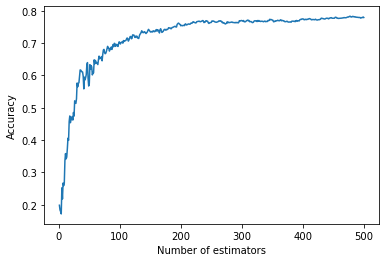

Accuracy: 77.91% over 500 trees after 7182.45 seconds


In [18]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=1)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

Iteration starting after 0.01 seconds
Iteration 25 ended after 105.61 seconds
Accuracy 25 (81.09%) took 1.46 seconds
Iteration 50 ended after 246.35 seconds
Accuracy 50 (85.25%) took 2.71 seconds
Iteration 75 ended after 420.19 seconds
Accuracy 75 (86.91%) took 4.03 seconds
Iteration 100 ended after 628.58 seconds
Accuracy 100 (88.26%) took 5.40 seconds
Iteration 125 ended after 871.81 seconds
Accuracy 125 (89.08%) took 6.70 seconds
Iteration 150 ended after 1154.77 seconds
Accuracy 150 (89.92%) took 9.92 seconds
Iteration 175 ended after 1482.82 seconds
Accuracy 175 (90.17%) took 10.16 seconds
Iteration 200 ended after 1825.78 seconds
Accuracy 200 (90.33%) took 10.69 seconds
Iteration 225 ended after 2202.25 seconds
Accuracy 225 (90.86%) took 12.99 seconds
Iteration 250 ended after 2621.10 seconds
Accuracy 250 (91.05%) took 14.08 seconds
Iteration 275 ended after 3068.25 seconds
Accuracy 275 (91.22%) took 14.77 seconds
Iteration 300 ended after 3547.13 seconds
Accuracy 300 (91.69%) to

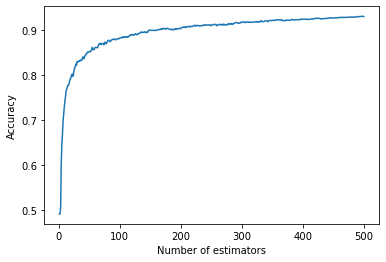

Accuracy: 93.00% over 500 trees after 8659.01 seconds


In [19]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=3)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

Iteration starting after 0.01 seconds
Iteration 25 ended after 225.93 seconds
Accuracy 25 (89.31%) took 1.74 seconds
Iteration 50 ended after 467.26 seconds
Accuracy 50 (92.51%) took 3.51 seconds
Iteration 75 ended after 755.50 seconds
Accuracy 75 (93.73%) took 5.30 seconds
Iteration 100 ended after 1087.86 seconds
Accuracy 100 (94.98%) took 7.08 seconds
Iteration 125 ended after 1473.10 seconds
Accuracy 125 (95.61%) took 11.05 seconds
Iteration 150 ended after 1944.10 seconds
Accuracy 150 (96.01%) took 10.81 seconds
Iteration 175 ended after 2432.07 seconds
Accuracy 175 (96.43%) took 13.53 seconds
Iteration 200 ended after 3069.64 seconds
Accuracy 200 (96.61%) took 34.26 seconds
Iteration 225 ended after 4253.54 seconds
Accuracy 225 (96.87%) took 35.92 seconds
Iteration 250 ended after 5487.50 seconds
Accuracy 250 (97.04%) took 40.94 seconds
Iteration 275 ended after 6621.53 seconds
Accuracy 275 (96.99%) took 24.94 seconds
Iteration 300 ended after 7292.10 seconds
Accuracy 300 (97.10%

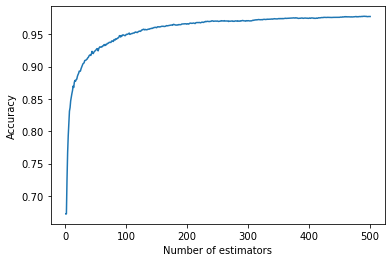

Accuracy: 97.74% over 500 trees after 13048.22 seconds


In [23]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=5)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

In [33]:
start = time()
n_estimators=500
booster1 = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=1)).fit(Xtrain, Ytrain, verbose=25)
y_hat = booster1.predict(Xtrain)
print(f"Train accuracy: {booster1.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster1.accuracy(booster1.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Iteration starting after 0.01 seconds
Iteration 25 ended after 51.83 seconds
Iteration 50 ended after 108.99 seconds
Iteration 75 ended after 168.12 seconds
Iteration 100 ended after 218.75 seconds
Iteration 125 ended after 260.70 seconds
Iteration 150 ended after 303.20 seconds
Iteration 175 ended after 346.64 seconds
Iteration 200 ended after 389.66 seconds
Iteration 225 ended after 431.59 seconds
Iteration 250 ended after 482.17 seconds
Iteration 275 ended after 526.35 seconds
Iteration 300 ended after 569.09 seconds
Iteration 325 ended after 611.66 seconds
Iteration 350 ended after 654.29 seconds
Iteration 375 ended after 696.87 seconds
Iteration 400 ended after 738.72 seconds
Iteration 425 ended after 781.83 seconds
Iteration 450 ended after 824.69 seconds
Iteration 475 ended after 866.41 seconds
Iteration 500 ended after 909.40 seconds
Train accuracy: 77.91% over 500 trees
Test accuracy: 78.36% over 500 trees


In [28]:
start = time()
n_estimators=500
booster2 = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).fit(Xtrain, Ytrain, verbose=25)
y_hat = booster2.predict(Xtrain)
print(f"Train accuracy: {booster2.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster2.accuracy(booster2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Iteration starting after 0.01 seconds
Iteration 25 ended after 85.01 seconds
Iteration 50 ended after 167.29 seconds
Iteration 75 ended after 236.82 seconds
Iteration 100 ended after 302.96 seconds
Iteration 125 ended after 369.71 seconds
Iteration 150 ended after 431.25 seconds
Iteration 175 ended after 493.29 seconds
Iteration 200 ended after 554.72 seconds
Iteration 225 ended after 616.57 seconds
Iteration 250 ended after 677.76 seconds
Iteration 275 ended after 739.39 seconds
Iteration 300 ended after 800.79 seconds
Iteration 325 ended after 862.36 seconds
Iteration 350 ended after 923.99 seconds
Iteration 375 ended after 986.47 seconds
Iteration 400 ended after 1047.93 seconds
Iteration 425 ended after 1109.20 seconds
Iteration 450 ended after 1172.35 seconds
Iteration 475 ended after 1233.94 seconds
Iteration 500 ended after 1295.65 seconds
Train accuracy: 87.35% over 500 trees
Test accuracy: 87.16% over 500 trees


In [31]:
start = time()
n_estimators=500
booster3 = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=3)).fit(Xtrain, Ytrain, verbose=25)
y_hat = booster3.predict(Xtrain)
print(f"Train accuracy: {booster3.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster3.accuracy(booster3.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Iteration starting after 0.01 seconds
Iteration 25 ended after 89.72 seconds
Iteration 50 ended after 178.37 seconds
Iteration 75 ended after 267.90 seconds
Iteration 100 ended after 356.75 seconds
Iteration 125 ended after 446.39 seconds
Iteration 150 ended after 535.00 seconds
Iteration 175 ended after 624.06 seconds
Iteration 200 ended after 713.40 seconds
Iteration 225 ended after 802.30 seconds
Iteration 250 ended after 893.66 seconds
Iteration 275 ended after 982.03 seconds
Iteration 300 ended after 1071.53 seconds
Iteration 325 ended after 1160.19 seconds
Iteration 350 ended after 1249.37 seconds
Iteration 375 ended after 1337.88 seconds
Iteration 400 ended after 1427.24 seconds
Iteration 425 ended after 1515.69 seconds
Iteration 450 ended after 1605.66 seconds
Iteration 475 ended after 1693.79 seconds
Iteration 500 ended after 1783.34 seconds
Train accuracy: 93.00% over 500 trees
Test accuracy: 92.00% over 500 trees


In [30]:
start = time()
n_estimators=500
booster5 = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=5)).fit(Xtrain, Ytrain, verbose=25)
y_hat = booster5.predict(Xtrain)
print(f"Train accuracy: {booster5.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster5.accuracy(booster5.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Iteration starting after 0.01 seconds
Iteration 25 ended after 142.87 seconds
Iteration 50 ended after 285.34 seconds
Iteration 75 ended after 426.87 seconds
Iteration 100 ended after 569.19 seconds
Iteration 125 ended after 710.90 seconds
Iteration 150 ended after 853.19 seconds
Iteration 175 ended after 995.70 seconds
Iteration 200 ended after 1137.48 seconds
Iteration 225 ended after 1279.32 seconds
Iteration 250 ended after 1423.33 seconds
Iteration 275 ended after 1564.98 seconds
Iteration 300 ended after 1707.99 seconds
Iteration 325 ended after 1849.78 seconds
Iteration 350 ended after 1993.33 seconds
Iteration 375 ended after 2135.79 seconds
Iteration 400 ended after 2277.31 seconds
Iteration 425 ended after 2419.18 seconds
Iteration 450 ended after 2562.00 seconds
Iteration 475 ended after 2704.06 seconds
Iteration 500 ended after 2847.01 seconds
Train accuracy: 97.74% over 500 trees
Test accuracy: 95.54% over 500 trees


Accuracy 25 (47.78% in 0.06 seconds) after 40.17 seconds
Accuracy 50 (56.70% in 0.07 seconds) after 74.75 seconds
Accuracy 75 (66.22% in 0.06 seconds) after 110.12 seconds
Accuracy 100 (69.93% in 0.06 seconds) after 145.31 seconds
Accuracy 125 (71.45% in 0.05 seconds) after 179.68 seconds
Accuracy 150 (73.60% in 0.07 seconds) after 216.85 seconds
Accuracy 175 (74.00% in 0.07 seconds) after 251.01 seconds
Accuracy 200 (75.38% in 0.07 seconds) after 286.24 seconds
Accuracy 225 (76.14% in 0.06 seconds) after 322.06 seconds
Accuracy 250 (76.42% in 0.05 seconds) after 359.99 seconds
Accuracy 275 (76.03% in 0.09 seconds) after 402.74 seconds
Accuracy 300 (77.06% in 0.09 seconds) after 447.06 seconds
Accuracy 325 (76.72% in 0.09 seconds) after 489.96 seconds
Accuracy 350 (77.03% in 0.07 seconds) after 534.53 seconds
Accuracy 375 (76.63% in 0.08 seconds) after 578.98 seconds
Accuracy 400 (77.46% in 0.10 seconds) after 622.71 seconds
Accuracy 425 (77.14% in 0.09 seconds) after 666.80 seconds
Ac

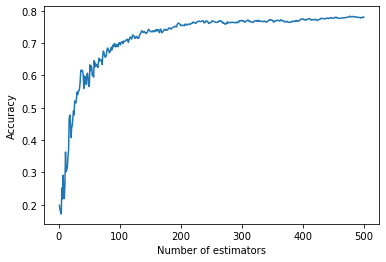

In [4]:
from functions import *
start = time()
n_estimators = 500
booster_update = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=1)).update_fit(Xtrain,Ytrain, verbose=25)

In [7]:
print(f"Train accuracy: {booster_update.accuracy(booster_update.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update.accuracy(booster_update.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Train accuracy: 77.91% over 500 trees
Test accuracy: 78.36% over 500 trees


Accuracy 25 (71.01% in 0.08 seconds) after 92.53 seconds
Accuracy 50 (78.25% in 0.10 seconds) after 169.92 seconds
Accuracy 75 (80.19% in 0.09 seconds) after 257.05 seconds
Accuracy 100 (81.20% in 0.07 seconds) after 322.55 seconds
Accuracy 125 (83.78% in 0.09 seconds) after 384.65 seconds
Accuracy 150 (83.75% in 0.07 seconds) after 447.53 seconds
Accuracy 175 (84.33% in 0.06 seconds) after 512.29 seconds
Accuracy 200 (85.05% in 0.14 seconds) after 582.19 seconds
Accuracy 225 (84.66% in 0.06 seconds) after 652.51 seconds
Accuracy 250 (85.52% in 0.07 seconds) after 716.00 seconds
Accuracy 275 (85.43% in 0.06 seconds) after 778.78 seconds
Accuracy 300 (85.56% in 0.07 seconds) after 841.03 seconds
Accuracy 325 (86.11% in 0.06 seconds) after 903.47 seconds
Accuracy 350 (86.19% in 0.06 seconds) after 965.69 seconds
Accuracy 375 (86.70% in 0.06 seconds) after 1029.33 seconds
Accuracy 400 (86.64% in 0.06 seconds) after 1091.72 seconds
Accuracy 425 (86.44% in 0.08 seconds) after 1154.28 second

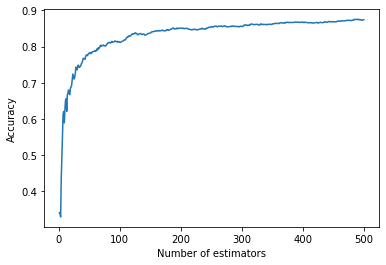

Train accuracy: 87.35% over 500 trees
Test accuracy: 87.16% over 500 trees


In [8]:
booster_update2 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).update_fit(Xtrain,Ytrain, verbose=25)
print(f"Train accuracy: {booster_update2.accuracy(booster_update2.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update2.accuracy(booster_update2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Accuracy 25 (75.25% in 0.07 seconds) after 99.63 seconds
Accuracy 50 (82.09% in 0.06 seconds) after 191.90 seconds
Accuracy 75 (85.39% in 0.07 seconds) after 282.13 seconds
Accuracy 100 (86.69% in 0.06 seconds) after 372.78 seconds
Accuracy 125 (87.77% in 0.06 seconds) after 461.76 seconds
Accuracy 150 (88.83% in 0.06 seconds) after 551.44 seconds
Accuracy 175 (89.21% in 0.09 seconds) after 640.24 seconds
Accuracy 200 (89.92% in 0.06 seconds) after 729.45 seconds
Accuracy 225 (90.32% in 0.07 seconds) after 817.64 seconds
Accuracy 250 (90.85% in 0.08 seconds) after 907.29 seconds
Accuracy 275 (91.22% in 0.06 seconds) after 995.93 seconds
Accuracy 300 (91.47% in 0.08 seconds) after 1085.13 seconds
Accuracy 325 (91.69% in 0.08 seconds) after 1173.44 seconds
Accuracy 350 (91.98% in 0.06 seconds) after 1262.89 seconds
Accuracy 375 (92.06% in 0.06 seconds) after 1351.68 seconds
Accuracy 400 (92.26% in 0.08 seconds) after 1441.22 seconds
Accuracy 425 (92.44% in 0.06 seconds) after 1529.63 sec

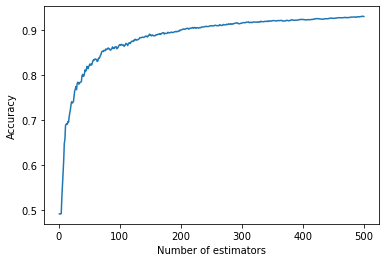

Train accuracy: 93.00% over 500 trees
Test accuracy: 92.00% over 500 trees


In [9]:
booster_update3 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=3)).update_fit(Xtrain,Ytrain, verbose=25)
print(f"Train accuracy: {booster_update3.accuracy(booster_update3.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update3.accuracy(booster_update3.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Accuracy 25 (83.28% in 0.07 seconds) after 140.75 seconds
Accuracy 50 (89.63% in 0.06 seconds) after 282.26 seconds
Accuracy 75 (92.12% in 0.06 seconds) after 423.01 seconds
Accuracy 100 (93.74% in 0.09 seconds) after 564.16 seconds
Accuracy 125 (94.73% in 0.06 seconds) after 704.97 seconds
Accuracy 150 (95.32% in 0.06 seconds) after 846.16 seconds
Accuracy 175 (95.88% in 0.06 seconds) after 987.29 seconds
Accuracy 200 (96.19% in 0.08 seconds) after 1130.72 seconds
Accuracy 225 (96.46% in 0.07 seconds) after 1279.78 seconds
Accuracy 250 (96.67% in 0.07 seconds) after 1420.86 seconds
Accuracy 275 (96.78% in 0.07 seconds) after 1561.66 seconds
Accuracy 300 (96.87% in 0.09 seconds) after 1703.09 seconds
Accuracy 325 (97.06% in 0.08 seconds) after 1844.82 seconds
Accuracy 350 (97.24% in 0.07 seconds) after 1985.68 seconds
Accuracy 375 (97.35% in 0.08 seconds) after 2127.36 seconds
Accuracy 400 (97.32% in 0.08 seconds) after 2268.08 seconds
Accuracy 425 (97.42% in 0.08 seconds) after 2408.7

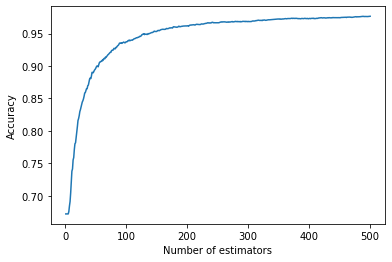

Train accuracy: 97.74% over 500 trees
Test accuracy: 95.54% over 500 trees


In [10]:
booster_update5 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=5)).update_fit(Xtrain,Ytrain, verbose=25)
print(f"Train accuracy: {booster_update5.accuracy(booster_update5.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update5.accuracy(booster_update5.predict(Xtest),Ytest):.2%} over {n_estimators} trees")